In [8]:
# coding: utf-8

# In[1]:


from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

In [14]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                
    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

    
    
    
    

W1004 14:21:07.103528 14568 deprecation_wrapper.py:119] From c:\users\praveen\anaconda3\envs\tf\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1004 14:21:07.108765 14568 deprecation_wrapper.py:119] From c:\users\praveen\anaconda3\envs\tf\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 14:21:07.159438 14568 deprecation_wrapper.py:119] From c:\users\praveen\anaconda3\envs\tf\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1004 14:21:07.288428 14568 deprecation_wrapper.py:119] From c:\users\praveen\anaconda3\envs\tf\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1004 14:21:07.299632 14568 deprecation_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


W1004 14:21:07.559820 14568 deprecation_wrapper.py:119] From c:\users\praveen\anaconda3\envs\tf\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
__________

c:\users\praveen\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.665691, acc.: 50.00%] [G loss: 0.583208]


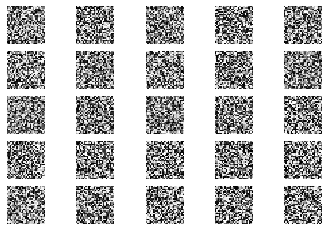

c:\users\praveen\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.574630, acc.: 59.38%] [G loss: 0.654310]
2 [D loss: 0.396496, acc.: 78.12%] [G loss: 0.778314]
3 [D loss: 0.355499, acc.: 82.81%] [G loss: 0.906961]
4 [D loss: 0.288864, acc.: 85.94%] [G loss: 1.081453]
5 [D loss: 0.270583, acc.: 96.88%] [G loss: 1.131019]
6 [D loss: 0.207014, acc.: 98.44%] [G loss: 1.247911]
7 [D loss: 0.206045, acc.: 98.44%] [G loss: 1.373942]
8 [D loss: 0.198561, acc.: 98.44%] [G loss: 1.559226]
9 [D loss: 0.149237, acc.: 100.00%] [G loss: 1.547873]
10 [D loss: 0.148003, acc.: 100.00%] [G loss: 1.631627]
11 [D loss: 0.151847, acc.: 98.44%] [G loss: 1.743870]
12 [D loss: 0.131484, acc.: 100.00%] [G loss: 1.816094]
13 [D loss: 0.117402, acc.: 100.00%] [G loss: 1.910719]
14 [D loss: 0.094865, acc.: 100.00%] [G loss: 2.032083]
15 [D loss: 0.097973, acc.: 100.00%] [G loss: 2.058912]
16 [D loss: 0.090522, acc.: 100.00%] [G loss: 2.178648]
17 [D loss: 0.068811, acc.: 100.00%] [G loss: 2.241183]
18 [D loss: 0.071478, acc.: 100.00%] [G loss: 2.326802]
19 [D loss

149 [D loss: 0.046024, acc.: 100.00%] [G loss: 4.218585]
150 [D loss: 0.204061, acc.: 93.75%] [G loss: 3.491047]
151 [D loss: 0.153092, acc.: 95.31%] [G loss: 3.768533]
152 [D loss: 0.095601, acc.: 96.88%] [G loss: 3.410336]
153 [D loss: 0.106222, acc.: 98.44%] [G loss: 3.305749]
154 [D loss: 0.216610, acc.: 92.19%] [G loss: 2.978174]
155 [D loss: 0.152214, acc.: 95.31%] [G loss: 3.607147]
156 [D loss: 0.516971, acc.: 68.75%] [G loss: 3.064633]
157 [D loss: 0.117321, acc.: 98.44%] [G loss: 3.650559]
158 [D loss: 0.191435, acc.: 92.19%] [G loss: 3.297668]
159 [D loss: 0.115323, acc.: 96.88%] [G loss: 3.374631]
160 [D loss: 0.225856, acc.: 92.19%] [G loss: 3.449375]
161 [D loss: 0.281880, acc.: 84.38%] [G loss: 3.260049]
162 [D loss: 0.125533, acc.: 96.88%] [G loss: 3.699538]
163 [D loss: 0.183263, acc.: 98.44%] [G loss: 3.294302]
164 [D loss: 0.386489, acc.: 84.38%] [G loss: 3.770926]
165 [D loss: 0.496804, acc.: 71.88%] [G loss: 3.889897]
166 [D loss: 0.384094, acc.: 89.06%] [G loss: 3

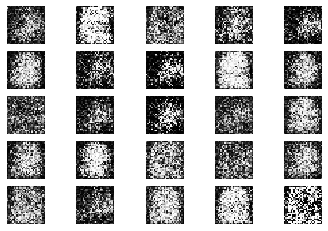

201 [D loss: 0.630165, acc.: 67.19%] [G loss: 2.612260]
202 [D loss: 0.253369, acc.: 87.50%] [G loss: 2.993505]
203 [D loss: 0.383823, acc.: 89.06%] [G loss: 3.238851]
204 [D loss: 0.178649, acc.: 93.75%] [G loss: 3.270772]
205 [D loss: 0.158059, acc.: 96.88%] [G loss: 3.752764]
206 [D loss: 0.207935, acc.: 92.19%] [G loss: 2.981586]
207 [D loss: 0.150781, acc.: 98.44%] [G loss: 2.856401]
208 [D loss: 0.395203, acc.: 90.62%] [G loss: 3.034051]
209 [D loss: 0.551882, acc.: 75.00%] [G loss: 1.885173]
210 [D loss: 0.299465, acc.: 84.38%] [G loss: 3.759605]
211 [D loss: 0.504407, acc.: 79.69%] [G loss: 2.943299]
212 [D loss: 0.216689, acc.: 93.75%] [G loss: 3.125337]
213 [D loss: 0.421230, acc.: 79.69%] [G loss: 2.740520]
214 [D loss: 0.274278, acc.: 87.50%] [G loss: 3.190204]
215 [D loss: 0.331431, acc.: 90.62%] [G loss: 2.998737]
216 [D loss: 0.247995, acc.: 89.06%] [G loss: 3.154905]
217 [D loss: 0.597183, acc.: 79.69%] [G loss: 3.038522]
218 [D loss: 0.392310, acc.: 78.12%] [G loss: 3.

350 [D loss: 0.703845, acc.: 57.81%] [G loss: 0.936043]
351 [D loss: 0.702794, acc.: 60.94%] [G loss: 0.882139]
352 [D loss: 0.719906, acc.: 51.56%] [G loss: 0.830560]
353 [D loss: 0.679629, acc.: 56.25%] [G loss: 0.920382]
354 [D loss: 0.680683, acc.: 59.38%] [G loss: 0.964354]
355 [D loss: 0.701342, acc.: 53.12%] [G loss: 0.979723]
356 [D loss: 0.573495, acc.: 76.56%] [G loss: 1.001610]
357 [D loss: 0.555984, acc.: 71.88%] [G loss: 1.071548]
358 [D loss: 0.706909, acc.: 54.69%] [G loss: 1.120564]
359 [D loss: 0.637455, acc.: 62.50%] [G loss: 1.000616]
360 [D loss: 0.622712, acc.: 65.62%] [G loss: 0.958393]
361 [D loss: 0.556336, acc.: 75.00%] [G loss: 0.963254]
362 [D loss: 0.632863, acc.: 65.62%] [G loss: 1.083178]
363 [D loss: 0.693927, acc.: 60.94%] [G loss: 0.960307]
364 [D loss: 0.765226, acc.: 56.25%] [G loss: 0.849854]
365 [D loss: 0.584638, acc.: 68.75%] [G loss: 0.978594]
366 [D loss: 0.583268, acc.: 68.75%] [G loss: 1.043150]
367 [D loss: 0.592329, acc.: 70.31%] [G loss: 1.

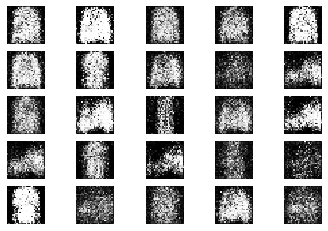

401 [D loss: 0.584949, acc.: 71.88%] [G loss: 0.959431]
402 [D loss: 0.609757, acc.: 62.50%] [G loss: 0.924821]
403 [D loss: 0.617744, acc.: 67.19%] [G loss: 0.949181]
404 [D loss: 0.663071, acc.: 59.38%] [G loss: 0.993382]
405 [D loss: 0.617766, acc.: 73.44%] [G loss: 0.991691]
406 [D loss: 0.621984, acc.: 68.75%] [G loss: 0.936269]
407 [D loss: 0.603327, acc.: 67.19%] [G loss: 0.923961]
408 [D loss: 0.605929, acc.: 71.88%] [G loss: 0.942628]
409 [D loss: 0.607104, acc.: 65.62%] [G loss: 0.886498]
410 [D loss: 0.688797, acc.: 51.56%] [G loss: 0.928882]
411 [D loss: 0.658001, acc.: 67.19%] [G loss: 0.922946]
412 [D loss: 0.603317, acc.: 65.62%] [G loss: 0.924767]
413 [D loss: 0.695303, acc.: 56.25%] [G loss: 0.888434]
414 [D loss: 0.655625, acc.: 57.81%] [G loss: 0.941276]
415 [D loss: 0.604427, acc.: 68.75%] [G loss: 1.037403]
416 [D loss: 0.668363, acc.: 53.12%] [G loss: 0.928376]
417 [D loss: 0.671227, acc.: 57.81%] [G loss: 0.866948]
418 [D loss: 0.623912, acc.: 54.69%] [G loss: 0.

547 [D loss: 0.609379, acc.: 71.88%] [G loss: 0.954077]
548 [D loss: 0.672208, acc.: 62.50%] [G loss: 0.937965]
549 [D loss: 0.679538, acc.: 50.00%] [G loss: 0.849651]
550 [D loss: 0.605294, acc.: 73.44%] [G loss: 0.850273]
551 [D loss: 0.635136, acc.: 59.38%] [G loss: 0.834826]
552 [D loss: 0.640072, acc.: 64.06%] [G loss: 0.885861]
553 [D loss: 0.638833, acc.: 65.62%] [G loss: 0.955645]
554 [D loss: 0.606333, acc.: 65.62%] [G loss: 0.879730]
555 [D loss: 0.631332, acc.: 65.62%] [G loss: 0.881652]
556 [D loss: 0.578301, acc.: 73.44%] [G loss: 0.953627]
557 [D loss: 0.633246, acc.: 67.19%] [G loss: 0.916881]
558 [D loss: 0.649287, acc.: 59.38%] [G loss: 0.894400]
559 [D loss: 0.654322, acc.: 60.94%] [G loss: 0.863363]
560 [D loss: 0.583943, acc.: 71.88%] [G loss: 0.892004]
561 [D loss: 0.635563, acc.: 67.19%] [G loss: 0.837674]
562 [D loss: 0.662861, acc.: 60.94%] [G loss: 0.894676]
563 [D loss: 0.590546, acc.: 70.31%] [G loss: 0.882654]
564 [D loss: 0.670348, acc.: 64.06%] [G loss: 0.

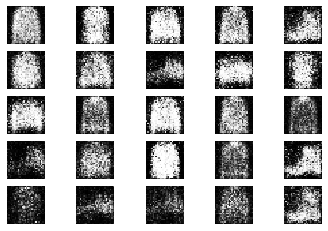

601 [D loss: 0.641564, acc.: 65.62%] [G loss: 0.854142]
602 [D loss: 0.714557, acc.: 50.00%] [G loss: 0.978500]
603 [D loss: 0.673666, acc.: 60.94%] [G loss: 0.896625]
604 [D loss: 0.652368, acc.: 57.81%] [G loss: 0.897526]
605 [D loss: 0.672333, acc.: 59.38%] [G loss: 0.866792]
606 [D loss: 0.632943, acc.: 67.19%] [G loss: 0.869491]
607 [D loss: 0.715175, acc.: 50.00%] [G loss: 0.823513]
608 [D loss: 0.637458, acc.: 60.94%] [G loss: 0.786662]
609 [D loss: 0.623211, acc.: 60.94%] [G loss: 0.863643]
610 [D loss: 0.636671, acc.: 62.50%] [G loss: 0.907060]
611 [D loss: 0.616444, acc.: 68.75%] [G loss: 0.868336]
612 [D loss: 0.656281, acc.: 54.69%] [G loss: 0.782462]
613 [D loss: 0.646464, acc.: 56.25%] [G loss: 0.801840]
614 [D loss: 0.603482, acc.: 64.06%] [G loss: 0.871754]
615 [D loss: 0.656176, acc.: 64.06%] [G loss: 0.834648]
616 [D loss: 0.569575, acc.: 67.19%] [G loss: 0.849851]
617 [D loss: 0.685461, acc.: 53.12%] [G loss: 0.941126]
618 [D loss: 0.712479, acc.: 57.81%] [G loss: 1.

750 [D loss: 0.664283, acc.: 51.56%] [G loss: 0.802602]
751 [D loss: 0.660366, acc.: 62.50%] [G loss: 0.856321]
752 [D loss: 0.674601, acc.: 59.38%] [G loss: 0.886850]
753 [D loss: 0.605974, acc.: 68.75%] [G loss: 0.826695]
754 [D loss: 0.617331, acc.: 67.19%] [G loss: 0.862307]
755 [D loss: 0.638063, acc.: 65.62%] [G loss: 0.774682]
756 [D loss: 0.661461, acc.: 48.44%] [G loss: 0.811009]
757 [D loss: 0.617519, acc.: 70.31%] [G loss: 0.866328]
758 [D loss: 0.592935, acc.: 75.00%] [G loss: 0.848255]
759 [D loss: 0.595396, acc.: 68.75%] [G loss: 0.921015]
760 [D loss: 0.678682, acc.: 56.25%] [G loss: 0.854028]
761 [D loss: 0.582265, acc.: 73.44%] [G loss: 0.912271]
762 [D loss: 0.599915, acc.: 64.06%] [G loss: 0.890980]
763 [D loss: 0.665057, acc.: 57.81%] [G loss: 0.901496]
764 [D loss: 0.661798, acc.: 67.19%] [G loss: 0.844341]
765 [D loss: 0.665060, acc.: 59.38%] [G loss: 0.904194]
766 [D loss: 0.628838, acc.: 62.50%] [G loss: 1.004218]
767 [D loss: 0.661425, acc.: 62.50%] [G loss: 0.

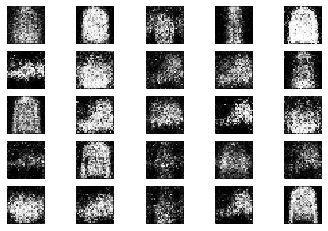

801 [D loss: 0.664915, acc.: 56.25%] [G loss: 0.833672]
802 [D loss: 0.662135, acc.: 62.50%] [G loss: 0.836901]
803 [D loss: 0.616204, acc.: 65.62%] [G loss: 0.899929]
804 [D loss: 0.685110, acc.: 50.00%] [G loss: 0.865402]
805 [D loss: 0.589970, acc.: 79.69%] [G loss: 0.908754]
806 [D loss: 0.647744, acc.: 67.19%] [G loss: 0.934967]
807 [D loss: 0.615825, acc.: 65.62%] [G loss: 0.866421]
808 [D loss: 0.616102, acc.: 73.44%] [G loss: 0.830167]
809 [D loss: 0.654025, acc.: 54.69%] [G loss: 0.828779]
810 [D loss: 0.609156, acc.: 68.75%] [G loss: 0.809954]
811 [D loss: 0.646684, acc.: 60.94%] [G loss: 0.823310]
812 [D loss: 0.594862, acc.: 68.75%] [G loss: 0.759365]
813 [D loss: 0.563567, acc.: 71.88%] [G loss: 0.852359]
814 [D loss: 0.658754, acc.: 62.50%] [G loss: 0.796562]
815 [D loss: 0.622950, acc.: 60.94%] [G loss: 0.892395]
816 [D loss: 0.605232, acc.: 60.94%] [G loss: 0.884466]
817 [D loss: 0.669738, acc.: 53.12%] [G loss: 0.934374]
818 [D loss: 0.667028, acc.: 56.25%] [G loss: 0.

947 [D loss: 0.598157, acc.: 64.06%] [G loss: 0.873448]
948 [D loss: 0.520173, acc.: 81.25%] [G loss: 0.955154]
949 [D loss: 0.626664, acc.: 68.75%] [G loss: 0.933945]
950 [D loss: 0.543317, acc.: 75.00%] [G loss: 0.975658]
951 [D loss: 0.633254, acc.: 64.06%] [G loss: 1.026931]
952 [D loss: 0.593207, acc.: 65.62%] [G loss: 0.967789]
953 [D loss: 0.626693, acc.: 64.06%] [G loss: 0.955217]
954 [D loss: 0.588295, acc.: 71.88%] [G loss: 0.970355]
955 [D loss: 0.617590, acc.: 67.19%] [G loss: 0.947160]
956 [D loss: 0.570511, acc.: 76.56%] [G loss: 0.970465]
957 [D loss: 0.631839, acc.: 53.12%] [G loss: 0.896207]
958 [D loss: 0.588184, acc.: 68.75%] [G loss: 0.891945]
959 [D loss: 0.605058, acc.: 65.62%] [G loss: 0.905532]
960 [D loss: 0.601428, acc.: 65.62%] [G loss: 0.939085]
961 [D loss: 0.638016, acc.: 56.25%] [G loss: 0.896806]
962 [D loss: 0.662447, acc.: 59.38%] [G loss: 0.925909]
963 [D loss: 0.587441, acc.: 65.62%] [G loss: 0.937042]
964 [D loss: 0.627583, acc.: 62.50%] [G loss: 0.

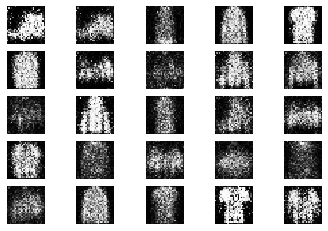

1001 [D loss: 0.638960, acc.: 70.31%] [G loss: 0.952523]
1002 [D loss: 0.584920, acc.: 75.00%] [G loss: 0.858442]
1003 [D loss: 0.570297, acc.: 75.00%] [G loss: 0.906263]
1004 [D loss: 0.545828, acc.: 76.56%] [G loss: 0.986289]
1005 [D loss: 0.595953, acc.: 71.88%] [G loss: 0.976629]
1006 [D loss: 0.672819, acc.: 64.06%] [G loss: 0.975551]
1007 [D loss: 0.710850, acc.: 53.12%] [G loss: 0.828701]
1008 [D loss: 0.587080, acc.: 68.75%] [G loss: 0.936908]
1009 [D loss: 0.568118, acc.: 78.12%] [G loss: 0.989303]
1010 [D loss: 0.601858, acc.: 65.62%] [G loss: 0.945823]
1011 [D loss: 0.589614, acc.: 68.75%] [G loss: 0.925990]
1012 [D loss: 0.576254, acc.: 70.31%] [G loss: 0.903478]
1013 [D loss: 0.645530, acc.: 57.81%] [G loss: 0.851282]
1014 [D loss: 0.594018, acc.: 68.75%] [G loss: 0.981924]
1015 [D loss: 0.580847, acc.: 68.75%] [G loss: 0.957526]
1016 [D loss: 0.556459, acc.: 73.44%] [G loss: 0.919982]
1017 [D loss: 0.590276, acc.: 65.62%] [G loss: 1.017584]
1018 [D loss: 0.581169, acc.: 6

1146 [D loss: 0.559021, acc.: 71.88%] [G loss: 0.826390]
1147 [D loss: 0.599130, acc.: 67.19%] [G loss: 0.977212]
1148 [D loss: 0.615661, acc.: 68.75%] [G loss: 0.875006]
1149 [D loss: 0.701011, acc.: 56.25%] [G loss: 0.909853]
1150 [D loss: 0.657349, acc.: 60.94%] [G loss: 0.843725]
1151 [D loss: 0.641237, acc.: 67.19%] [G loss: 0.857515]
1152 [D loss: 0.602639, acc.: 64.06%] [G loss: 0.908918]
1153 [D loss: 0.710959, acc.: 53.12%] [G loss: 0.804147]
1154 [D loss: 0.649408, acc.: 57.81%] [G loss: 0.754252]
1155 [D loss: 0.636894, acc.: 67.19%] [G loss: 0.864427]
1156 [D loss: 0.624988, acc.: 67.19%] [G loss: 0.840030]
1157 [D loss: 0.652141, acc.: 56.25%] [G loss: 0.924894]
1158 [D loss: 0.699129, acc.: 53.12%] [G loss: 0.909221]
1159 [D loss: 0.565231, acc.: 73.44%] [G loss: 0.946410]
1160 [D loss: 0.677121, acc.: 57.81%] [G loss: 0.837072]
1161 [D loss: 0.640276, acc.: 62.50%] [G loss: 0.971146]
1162 [D loss: 0.649426, acc.: 60.94%] [G loss: 0.901531]
1163 [D loss: 0.692183, acc.: 5

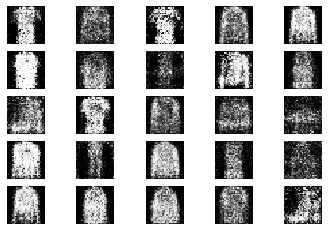

1201 [D loss: 0.652006, acc.: 59.38%] [G loss: 0.932431]
1202 [D loss: 0.628777, acc.: 64.06%] [G loss: 0.909728]
1203 [D loss: 0.697477, acc.: 51.56%] [G loss: 0.855417]
1204 [D loss: 0.621498, acc.: 65.62%] [G loss: 0.950981]
1205 [D loss: 0.601016, acc.: 59.38%] [G loss: 0.909586]
1206 [D loss: 0.613812, acc.: 65.62%] [G loss: 0.877423]
1207 [D loss: 0.657048, acc.: 60.94%] [G loss: 0.847981]
1208 [D loss: 0.585947, acc.: 67.19%] [G loss: 0.901610]
1209 [D loss: 0.681889, acc.: 57.81%] [G loss: 0.845305]
1210 [D loss: 0.665721, acc.: 60.94%] [G loss: 0.792695]
1211 [D loss: 0.689899, acc.: 65.62%] [G loss: 0.873615]
1212 [D loss: 0.652706, acc.: 57.81%] [G loss: 0.810026]
1213 [D loss: 0.628241, acc.: 64.06%] [G loss: 0.901251]
1214 [D loss: 0.623492, acc.: 65.62%] [G loss: 0.914119]
1215 [D loss: 0.666491, acc.: 56.25%] [G loss: 0.831921]
1216 [D loss: 0.688223, acc.: 50.00%] [G loss: 0.851554]
1217 [D loss: 0.679286, acc.: 54.69%] [G loss: 0.890969]
1218 [D loss: 0.610618, acc.: 6

1346 [D loss: 0.606440, acc.: 68.75%] [G loss: 0.906671]
1347 [D loss: 0.591011, acc.: 71.88%] [G loss: 0.888239]
1348 [D loss: 0.613557, acc.: 60.94%] [G loss: 0.824983]
1349 [D loss: 0.673938, acc.: 64.06%] [G loss: 0.919742]
1350 [D loss: 0.638968, acc.: 62.50%] [G loss: 0.857281]
1351 [D loss: 0.575281, acc.: 70.31%] [G loss: 0.899169]
1352 [D loss: 0.695214, acc.: 53.12%] [G loss: 0.956201]
1353 [D loss: 0.647209, acc.: 62.50%] [G loss: 0.952619]
1354 [D loss: 0.683218, acc.: 50.00%] [G loss: 0.885865]
1355 [D loss: 0.689849, acc.: 56.25%] [G loss: 0.906267]
1356 [D loss: 0.624496, acc.: 65.62%] [G loss: 0.879008]
1357 [D loss: 0.696859, acc.: 60.94%] [G loss: 0.981182]
1358 [D loss: 0.653604, acc.: 65.62%] [G loss: 0.882089]
1359 [D loss: 0.623894, acc.: 59.38%] [G loss: 0.826863]
1360 [D loss: 0.666973, acc.: 51.56%] [G loss: 0.878804]
1361 [D loss: 0.694029, acc.: 60.94%] [G loss: 0.857290]
1362 [D loss: 0.653344, acc.: 64.06%] [G loss: 0.929191]
1363 [D loss: 0.650723, acc.: 6

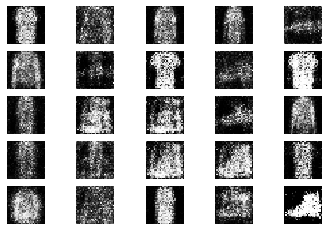

1401 [D loss: 0.667137, acc.: 57.81%] [G loss: 0.839934]
1402 [D loss: 0.682862, acc.: 54.69%] [G loss: 0.828284]
1403 [D loss: 0.605951, acc.: 68.75%] [G loss: 0.860273]
1404 [D loss: 0.585620, acc.: 73.44%] [G loss: 0.950952]
1405 [D loss: 0.657117, acc.: 59.38%] [G loss: 0.908193]
1406 [D loss: 0.632021, acc.: 65.62%] [G loss: 0.868726]
1407 [D loss: 0.634824, acc.: 60.94%] [G loss: 0.833946]
1408 [D loss: 0.623479, acc.: 64.06%] [G loss: 0.816498]
1409 [D loss: 0.675402, acc.: 54.69%] [G loss: 0.882130]
1410 [D loss: 0.621645, acc.: 64.06%] [G loss: 0.874747]
1411 [D loss: 0.638565, acc.: 64.06%] [G loss: 0.841111]
1412 [D loss: 0.568607, acc.: 76.56%] [G loss: 0.864358]
1413 [D loss: 0.617815, acc.: 60.94%] [G loss: 0.848346]
1414 [D loss: 0.624179, acc.: 67.19%] [G loss: 0.861329]
1415 [D loss: 0.683813, acc.: 54.69%] [G loss: 0.836517]
1416 [D loss: 0.578088, acc.: 78.12%] [G loss: 0.893587]
1417 [D loss: 0.563650, acc.: 75.00%] [G loss: 0.818886]
1418 [D loss: 0.672790, acc.: 6

1544 [D loss: 0.617812, acc.: 65.62%] [G loss: 0.917139]
1545 [D loss: 0.597772, acc.: 73.44%] [G loss: 0.814257]
1546 [D loss: 0.618007, acc.: 71.88%] [G loss: 0.892993]
1547 [D loss: 0.638389, acc.: 67.19%] [G loss: 0.903250]
1548 [D loss: 0.645071, acc.: 57.81%] [G loss: 0.890522]
1549 [D loss: 0.558859, acc.: 78.12%] [G loss: 0.859936]
1550 [D loss: 0.621179, acc.: 56.25%] [G loss: 0.895345]
1551 [D loss: 0.614889, acc.: 70.31%] [G loss: 0.827161]
1552 [D loss: 0.592030, acc.: 70.31%] [G loss: 0.948587]
1553 [D loss: 0.671810, acc.: 54.69%] [G loss: 0.955716]
1554 [D loss: 0.590070, acc.: 73.44%] [G loss: 0.957301]
1555 [D loss: 0.644471, acc.: 59.38%] [G loss: 0.879643]
1556 [D loss: 0.584779, acc.: 75.00%] [G loss: 0.902077]
1557 [D loss: 0.593616, acc.: 68.75%] [G loss: 0.848016]
1558 [D loss: 0.677926, acc.: 59.38%] [G loss: 0.867355]
1559 [D loss: 0.597719, acc.: 75.00%] [G loss: 0.873247]
1560 [D loss: 0.594951, acc.: 70.31%] [G loss: 0.842967]
1561 [D loss: 0.615720, acc.: 6

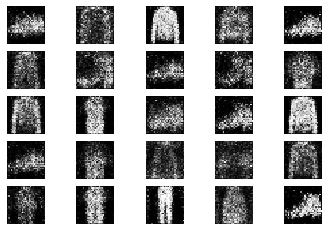

1601 [D loss: 0.636535, acc.: 65.62%] [G loss: 0.886211]
1602 [D loss: 0.656708, acc.: 51.56%] [G loss: 0.816955]
1603 [D loss: 0.668811, acc.: 64.06%] [G loss: 0.836795]
1604 [D loss: 0.671807, acc.: 54.69%] [G loss: 0.830737]
1605 [D loss: 0.600924, acc.: 67.19%] [G loss: 0.900634]
1606 [D loss: 0.630609, acc.: 62.50%] [G loss: 0.889394]
1607 [D loss: 0.570440, acc.: 73.44%] [G loss: 0.871592]
1608 [D loss: 0.657954, acc.: 57.81%] [G loss: 0.837963]
1609 [D loss: 0.599808, acc.: 67.19%] [G loss: 0.901239]
1610 [D loss: 0.673764, acc.: 60.94%] [G loss: 0.886857]
1611 [D loss: 0.663421, acc.: 59.38%] [G loss: 0.713214]
1612 [D loss: 0.610593, acc.: 62.50%] [G loss: 0.854001]
1613 [D loss: 0.622843, acc.: 65.62%] [G loss: 0.881726]
1614 [D loss: 0.628492, acc.: 60.94%] [G loss: 0.851658]
1615 [D loss: 0.623054, acc.: 60.94%] [G loss: 0.889584]
1616 [D loss: 0.620697, acc.: 56.25%] [G loss: 0.980063]
1617 [D loss: 0.596927, acc.: 67.19%] [G loss: 0.852963]
1618 [D loss: 0.641935, acc.: 6

1745 [D loss: 0.598487, acc.: 71.88%] [G loss: 0.860949]
1746 [D loss: 0.657167, acc.: 57.81%] [G loss: 0.867454]
1747 [D loss: 0.639724, acc.: 60.94%] [G loss: 0.876830]
1748 [D loss: 0.615410, acc.: 65.62%] [G loss: 0.844838]
1749 [D loss: 0.605207, acc.: 65.62%] [G loss: 0.943745]
1750 [D loss: 0.651959, acc.: 60.94%] [G loss: 0.880359]
1751 [D loss: 0.678764, acc.: 59.38%] [G loss: 0.886392]
1752 [D loss: 0.645127, acc.: 56.25%] [G loss: 0.880229]
1753 [D loss: 0.627844, acc.: 65.62%] [G loss: 0.831105]
1754 [D loss: 0.672883, acc.: 57.81%] [G loss: 0.844009]
1755 [D loss: 0.619756, acc.: 65.62%] [G loss: 0.807590]
1756 [D loss: 0.653760, acc.: 54.69%] [G loss: 0.863341]
1757 [D loss: 0.646198, acc.: 57.81%] [G loss: 0.894480]
1758 [D loss: 0.626314, acc.: 65.62%] [G loss: 0.851439]
1759 [D loss: 0.625378, acc.: 62.50%] [G loss: 0.745649]
1760 [D loss: 0.607232, acc.: 65.62%] [G loss: 0.837977]
1761 [D loss: 0.672136, acc.: 54.69%] [G loss: 0.925009]
1762 [D loss: 0.635470, acc.: 6

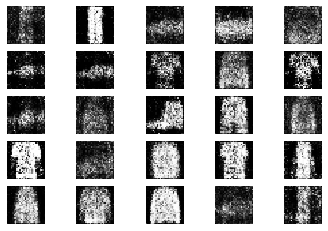

1801 [D loss: 0.652875, acc.: 64.06%] [G loss: 0.889219]
1802 [D loss: 0.640143, acc.: 65.62%] [G loss: 0.880671]
1803 [D loss: 0.616805, acc.: 67.19%] [G loss: 0.875326]
1804 [D loss: 0.622085, acc.: 70.31%] [G loss: 0.892179]
1805 [D loss: 0.647240, acc.: 57.81%] [G loss: 0.979261]
1806 [D loss: 0.614595, acc.: 62.50%] [G loss: 0.851500]
1807 [D loss: 0.654199, acc.: 60.94%] [G loss: 0.879609]
1808 [D loss: 0.621575, acc.: 71.88%] [G loss: 0.915180]
1809 [D loss: 0.536214, acc.: 78.12%] [G loss: 0.926616]
1810 [D loss: 0.696891, acc.: 54.69%] [G loss: 0.862167]
1811 [D loss: 0.643449, acc.: 64.06%] [G loss: 0.867570]
1812 [D loss: 0.588619, acc.: 65.62%] [G loss: 0.883849]
1813 [D loss: 0.575376, acc.: 65.62%] [G loss: 0.864191]
1814 [D loss: 0.661009, acc.: 64.06%] [G loss: 0.904403]
1815 [D loss: 0.639508, acc.: 64.06%] [G loss: 0.853719]
1816 [D loss: 0.634911, acc.: 62.50%] [G loss: 0.845150]
1817 [D loss: 0.612181, acc.: 59.38%] [G loss: 0.896975]
1818 [D loss: 0.663594, acc.: 5

1946 [D loss: 0.663116, acc.: 57.81%] [G loss: 0.833983]
1947 [D loss: 0.584289, acc.: 75.00%] [G loss: 0.764863]
1948 [D loss: 0.634932, acc.: 64.06%] [G loss: 0.863839]
1949 [D loss: 0.619661, acc.: 57.81%] [G loss: 0.906336]
1950 [D loss: 0.636278, acc.: 56.25%] [G loss: 0.852355]
1951 [D loss: 0.667288, acc.: 57.81%] [G loss: 0.937632]
1952 [D loss: 0.642708, acc.: 64.06%] [G loss: 0.905946]
1953 [D loss: 0.623632, acc.: 67.19%] [G loss: 0.906764]
1954 [D loss: 0.645556, acc.: 60.94%] [G loss: 0.893340]
1955 [D loss: 0.534068, acc.: 78.12%] [G loss: 0.861253]
1956 [D loss: 0.622636, acc.: 67.19%] [G loss: 0.847821]
1957 [D loss: 0.577668, acc.: 71.88%] [G loss: 0.857978]
1958 [D loss: 0.636064, acc.: 56.25%] [G loss: 0.945546]
1959 [D loss: 0.664370, acc.: 62.50%] [G loss: 0.930434]
1960 [D loss: 0.649081, acc.: 65.62%] [G loss: 0.912274]
1961 [D loss: 0.596748, acc.: 68.75%] [G loss: 0.902381]
1962 [D loss: 0.609365, acc.: 67.19%] [G loss: 0.925893]
1963 [D loss: 0.631689, acc.: 6

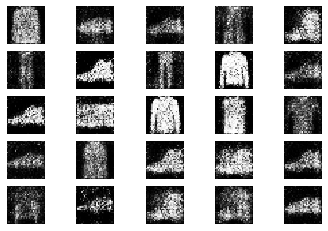

2001 [D loss: 0.594712, acc.: 68.75%] [G loss: 0.914106]
2002 [D loss: 0.621471, acc.: 67.19%] [G loss: 0.797977]
2003 [D loss: 0.667804, acc.: 60.94%] [G loss: 0.918426]
2004 [D loss: 0.686822, acc.: 57.81%] [G loss: 0.879609]
2005 [D loss: 0.677571, acc.: 56.25%] [G loss: 0.957613]
2006 [D loss: 0.665106, acc.: 65.62%] [G loss: 0.852789]
2007 [D loss: 0.632030, acc.: 64.06%] [G loss: 0.889996]
2008 [D loss: 0.615565, acc.: 65.62%] [G loss: 0.850440]
2009 [D loss: 0.636352, acc.: 67.19%] [G loss: 0.842117]
2010 [D loss: 0.653176, acc.: 62.50%] [G loss: 0.854853]
2011 [D loss: 0.609822, acc.: 68.75%] [G loss: 0.882464]
2012 [D loss: 0.626660, acc.: 70.31%] [G loss: 0.837404]
2013 [D loss: 0.622733, acc.: 64.06%] [G loss: 0.888322]
2014 [D loss: 0.629915, acc.: 67.19%] [G loss: 0.872100]
2015 [D loss: 0.665238, acc.: 60.94%] [G loss: 0.884853]
2016 [D loss: 0.595270, acc.: 68.75%] [G loss: 0.853533]
2017 [D loss: 0.617855, acc.: 67.19%] [G loss: 0.964851]
2018 [D loss: 0.599532, acc.: 7

2145 [D loss: 0.649122, acc.: 70.31%] [G loss: 0.936256]
2146 [D loss: 0.591585, acc.: 67.19%] [G loss: 0.923393]
2147 [D loss: 0.635604, acc.: 60.94%] [G loss: 0.916271]
2148 [D loss: 0.672012, acc.: 64.06%] [G loss: 0.924175]
2149 [D loss: 0.613967, acc.: 62.50%] [G loss: 0.889525]
2150 [D loss: 0.679046, acc.: 56.25%] [G loss: 0.888691]
2151 [D loss: 0.594082, acc.: 70.31%] [G loss: 0.847275]
2152 [D loss: 0.652004, acc.: 57.81%] [G loss: 0.852960]
2153 [D loss: 0.640704, acc.: 64.06%] [G loss: 0.858938]
2154 [D loss: 0.592157, acc.: 65.62%] [G loss: 0.859169]
2155 [D loss: 0.636463, acc.: 65.62%] [G loss: 0.928175]
2156 [D loss: 0.622896, acc.: 65.62%] [G loss: 0.968808]
2157 [D loss: 0.639545, acc.: 65.62%] [G loss: 0.835811]
2158 [D loss: 0.657764, acc.: 64.06%] [G loss: 0.828041]
2159 [D loss: 0.586473, acc.: 65.62%] [G loss: 0.807258]
2160 [D loss: 0.573978, acc.: 75.00%] [G loss: 0.794645]
2161 [D loss: 0.622640, acc.: 76.56%] [G loss: 0.796832]
2162 [D loss: 0.561092, acc.: 7

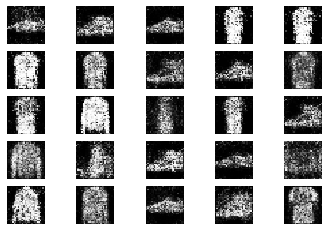

2201 [D loss: 0.587964, acc.: 73.44%] [G loss: 0.951688]
2202 [D loss: 0.621437, acc.: 62.50%] [G loss: 0.881709]
2203 [D loss: 0.633567, acc.: 64.06%] [G loss: 0.883290]
2204 [D loss: 0.626366, acc.: 62.50%] [G loss: 0.913897]
2205 [D loss: 0.635599, acc.: 67.19%] [G loss: 0.842661]
2206 [D loss: 0.622801, acc.: 59.38%] [G loss: 0.901874]
2207 [D loss: 0.672023, acc.: 59.38%] [G loss: 0.882654]
2208 [D loss: 0.627614, acc.: 65.62%] [G loss: 0.893432]
2209 [D loss: 0.609025, acc.: 60.94%] [G loss: 0.864401]
2210 [D loss: 0.703836, acc.: 57.81%] [G loss: 0.902328]
2211 [D loss: 0.668522, acc.: 56.25%] [G loss: 0.968412]
2212 [D loss: 0.563960, acc.: 78.12%] [G loss: 0.852787]
2213 [D loss: 0.577833, acc.: 70.31%] [G loss: 0.964741]
2214 [D loss: 0.668007, acc.: 50.00%] [G loss: 0.910727]
2215 [D loss: 0.602668, acc.: 64.06%] [G loss: 0.903462]
2216 [D loss: 0.597908, acc.: 68.75%] [G loss: 0.954495]
2217 [D loss: 0.571832, acc.: 71.88%] [G loss: 0.983818]
2218 [D loss: 0.597586, acc.: 7

2346 [D loss: 0.550121, acc.: 70.31%] [G loss: 1.002886]
2347 [D loss: 0.735601, acc.: 53.12%] [G loss: 0.941229]
2348 [D loss: 0.586684, acc.: 70.31%] [G loss: 0.933913]
2349 [D loss: 0.668552, acc.: 60.94%] [G loss: 0.989860]
2350 [D loss: 0.598101, acc.: 64.06%] [G loss: 0.936761]
2351 [D loss: 0.684435, acc.: 57.81%] [G loss: 0.974562]
2352 [D loss: 0.640440, acc.: 62.50%] [G loss: 1.026344]
2353 [D loss: 0.590284, acc.: 65.62%] [G loss: 0.970811]
2354 [D loss: 0.676071, acc.: 60.94%] [G loss: 0.899403]
2355 [D loss: 0.603068, acc.: 65.62%] [G loss: 1.016563]
2356 [D loss: 0.637454, acc.: 64.06%] [G loss: 0.901793]
2357 [D loss: 0.578711, acc.: 78.12%] [G loss: 0.940562]
2358 [D loss: 0.605022, acc.: 64.06%] [G loss: 0.907137]
2359 [D loss: 0.705058, acc.: 54.69%] [G loss: 0.941638]
2360 [D loss: 0.635587, acc.: 57.81%] [G loss: 0.988758]
2361 [D loss: 0.618362, acc.: 64.06%] [G loss: 0.941155]
2362 [D loss: 0.653804, acc.: 64.06%] [G loss: 0.908346]
2363 [D loss: 0.618712, acc.: 6

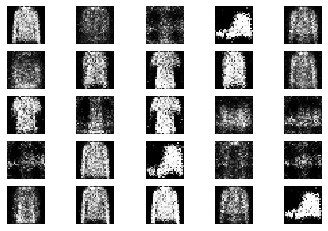

2401 [D loss: 0.654467, acc.: 62.50%] [G loss: 0.892450]
2402 [D loss: 0.583173, acc.: 67.19%] [G loss: 0.946297]
2403 [D loss: 0.648193, acc.: 60.94%] [G loss: 0.968201]
2404 [D loss: 0.605339, acc.: 67.19%] [G loss: 0.892011]
2405 [D loss: 0.617205, acc.: 70.31%] [G loss: 0.892648]
2406 [D loss: 0.576298, acc.: 71.88%] [G loss: 0.926083]
2407 [D loss: 0.622293, acc.: 65.62%] [G loss: 0.815601]
2408 [D loss: 0.642530, acc.: 56.25%] [G loss: 0.896893]
2409 [D loss: 0.629576, acc.: 64.06%] [G loss: 0.935274]
2410 [D loss: 0.622529, acc.: 70.31%] [G loss: 0.961239]
2411 [D loss: 0.617861, acc.: 70.31%] [G loss: 0.937484]
2412 [D loss: 0.655059, acc.: 54.69%] [G loss: 0.906965]
2413 [D loss: 0.685109, acc.: 56.25%] [G loss: 0.838740]
2414 [D loss: 0.626799, acc.: 60.94%] [G loss: 0.895204]
2415 [D loss: 0.694820, acc.: 56.25%] [G loss: 0.899671]
2416 [D loss: 0.661342, acc.: 60.94%] [G loss: 0.983637]
2417 [D loss: 0.575495, acc.: 73.44%] [G loss: 0.971372]
2418 [D loss: 0.698935, acc.: 5

2545 [D loss: 0.655230, acc.: 60.94%] [G loss: 0.973467]
2546 [D loss: 0.679873, acc.: 57.81%] [G loss: 0.891937]
2547 [D loss: 0.620982, acc.: 70.31%] [G loss: 0.899599]
2548 [D loss: 0.528173, acc.: 79.69%] [G loss: 0.898477]
2549 [D loss: 0.640075, acc.: 62.50%] [G loss: 0.895228]
2550 [D loss: 0.629443, acc.: 62.50%] [G loss: 0.937485]
2551 [D loss: 0.583331, acc.: 70.31%] [G loss: 0.901862]
2552 [D loss: 0.657279, acc.: 60.94%] [G loss: 0.884327]
2553 [D loss: 0.548585, acc.: 78.12%] [G loss: 0.877678]
2554 [D loss: 0.602948, acc.: 60.94%] [G loss: 0.873087]
2555 [D loss: 0.642731, acc.: 62.50%] [G loss: 0.926040]
2556 [D loss: 0.633749, acc.: 75.00%] [G loss: 0.993026]
2557 [D loss: 0.627740, acc.: 64.06%] [G loss: 0.930310]
2558 [D loss: 0.540715, acc.: 75.00%] [G loss: 0.874398]
2559 [D loss: 0.582952, acc.: 70.31%] [G loss: 0.884330]
2560 [D loss: 0.642161, acc.: 59.38%] [G loss: 0.900383]
2561 [D loss: 0.615514, acc.: 68.75%] [G loss: 0.844490]
2562 [D loss: 0.642547, acc.: 6

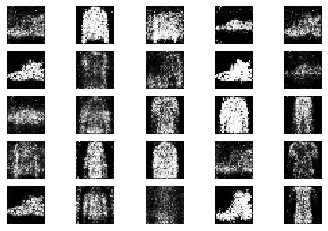

2601 [D loss: 0.678373, acc.: 59.38%] [G loss: 0.952857]
2602 [D loss: 0.571599, acc.: 70.31%] [G loss: 1.010240]
2603 [D loss: 0.605196, acc.: 65.62%] [G loss: 0.915315]
2604 [D loss: 0.573801, acc.: 64.06%] [G loss: 0.940181]
2605 [D loss: 0.656026, acc.: 51.56%] [G loss: 0.927909]
2606 [D loss: 0.589425, acc.: 65.62%] [G loss: 0.849899]
2607 [D loss: 0.648533, acc.: 54.69%] [G loss: 0.970157]
2608 [D loss: 0.660321, acc.: 59.38%] [G loss: 0.984248]
2609 [D loss: 0.585002, acc.: 73.44%] [G loss: 0.896626]
2610 [D loss: 0.650044, acc.: 65.62%] [G loss: 0.927651]
2611 [D loss: 0.620460, acc.: 64.06%] [G loss: 0.965573]
2612 [D loss: 0.710222, acc.: 50.00%] [G loss: 1.021384]
2613 [D loss: 0.613711, acc.: 67.19%] [G loss: 0.916575]
2614 [D loss: 0.689967, acc.: 53.12%] [G loss: 0.976729]
2615 [D loss: 0.704801, acc.: 50.00%] [G loss: 0.857474]
2616 [D loss: 0.593096, acc.: 64.06%] [G loss: 0.911683]
2617 [D loss: 0.539383, acc.: 73.44%] [G loss: 0.934500]
2618 [D loss: 0.679284, acc.: 5

2745 [D loss: 0.680114, acc.: 56.25%] [G loss: 0.976574]
2746 [D loss: 0.621096, acc.: 64.06%] [G loss: 0.982957]
2747 [D loss: 0.673625, acc.: 60.94%] [G loss: 0.990798]
2748 [D loss: 0.594527, acc.: 65.62%] [G loss: 0.915899]
2749 [D loss: 0.667642, acc.: 51.56%] [G loss: 0.949476]
2750 [D loss: 0.647048, acc.: 57.81%] [G loss: 0.900514]
2751 [D loss: 0.550964, acc.: 75.00%] [G loss: 0.987183]
2752 [D loss: 0.589058, acc.: 71.88%] [G loss: 0.978649]
2753 [D loss: 0.604531, acc.: 68.75%] [G loss: 0.997633]
2754 [D loss: 0.628027, acc.: 67.19%] [G loss: 0.880159]
2755 [D loss: 0.629320, acc.: 60.94%] [G loss: 0.941938]
2756 [D loss: 0.650980, acc.: 64.06%] [G loss: 0.891007]
2757 [D loss: 0.628051, acc.: 67.19%] [G loss: 0.861789]
2758 [D loss: 0.700057, acc.: 50.00%] [G loss: 0.865626]
2759 [D loss: 0.633991, acc.: 60.94%] [G loss: 0.870575]
2760 [D loss: 0.663983, acc.: 59.38%] [G loss: 1.005570]
2761 [D loss: 0.618507, acc.: 71.88%] [G loss: 0.869258]
2762 [D loss: 0.628600, acc.: 6

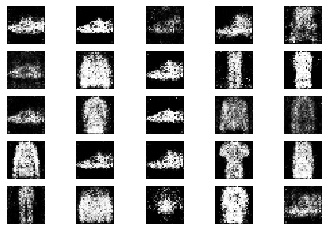

2801 [D loss: 0.599992, acc.: 71.88%] [G loss: 0.909092]
2802 [D loss: 0.600669, acc.: 71.88%] [G loss: 0.905846]
2803 [D loss: 0.633392, acc.: 68.75%] [G loss: 0.965604]
2804 [D loss: 0.626847, acc.: 64.06%] [G loss: 0.918863]
2805 [D loss: 0.575387, acc.: 67.19%] [G loss: 0.928075]
2806 [D loss: 0.678066, acc.: 53.12%] [G loss: 0.865866]
2807 [D loss: 0.609552, acc.: 64.06%] [G loss: 0.941872]
2808 [D loss: 0.606877, acc.: 70.31%] [G loss: 1.046983]
2809 [D loss: 0.647588, acc.: 65.62%] [G loss: 0.930651]
2810 [D loss: 0.653952, acc.: 62.50%] [G loss: 0.868140]
2811 [D loss: 0.587276, acc.: 67.19%] [G loss: 0.954057]
2812 [D loss: 0.656950, acc.: 62.50%] [G loss: 0.902094]
2813 [D loss: 0.650938, acc.: 57.81%] [G loss: 0.921135]
2814 [D loss: 0.696083, acc.: 50.00%] [G loss: 0.944712]
2815 [D loss: 0.595883, acc.: 64.06%] [G loss: 0.956201]
2816 [D loss: 0.548655, acc.: 76.56%] [G loss: 0.904046]
2817 [D loss: 0.628200, acc.: 60.94%] [G loss: 0.891663]
2818 [D loss: 0.688283, acc.: 5

2946 [D loss: 0.655683, acc.: 57.81%] [G loss: 0.895179]
2947 [D loss: 0.713761, acc.: 56.25%] [G loss: 0.919224]
2948 [D loss: 0.664937, acc.: 60.94%] [G loss: 1.009585]
2949 [D loss: 0.674678, acc.: 57.81%] [G loss: 0.899247]
2950 [D loss: 0.629140, acc.: 59.38%] [G loss: 0.852554]
2951 [D loss: 0.671149, acc.: 56.25%] [G loss: 0.814412]
2952 [D loss: 0.639068, acc.: 62.50%] [G loss: 0.837032]
2953 [D loss: 0.649918, acc.: 60.94%] [G loss: 0.866310]
2954 [D loss: 0.624983, acc.: 64.06%] [G loss: 0.817234]
2955 [D loss: 0.634110, acc.: 62.50%] [G loss: 0.872897]
2956 [D loss: 0.697906, acc.: 57.81%] [G loss: 0.884712]
2957 [D loss: 0.657945, acc.: 62.50%] [G loss: 0.856268]
2958 [D loss: 0.656451, acc.: 67.19%] [G loss: 0.909926]
2959 [D loss: 0.653567, acc.: 60.94%] [G loss: 0.909818]
2960 [D loss: 0.588977, acc.: 70.31%] [G loss: 0.836758]
2961 [D loss: 0.653306, acc.: 56.25%] [G loss: 0.905974]
2962 [D loss: 0.583659, acc.: 70.31%] [G loss: 0.892151]
2963 [D loss: 0.647000, acc.: 7

In [15]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=3000, batch_size=32, sample_interval=200)

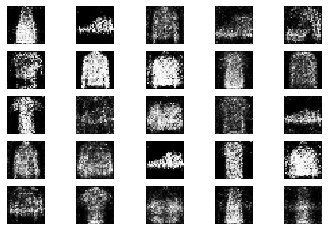

In [26]:
gan.sample_images(10)